# Preparación de los datos

In [1]:
# Importamos librerías a utilizar
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import warnings
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import display
import datetime

In [2]:
# Para que no se desplieguen las advertencias
warnings.filterwarnings("ignore")

## SIAP

### Cargamos los datos tidy

In [3]:
# Cultivos de interés
cultivos = ['Tomate rojo (jitomate)', 'Chile verde', 'Limón', 'Pepino', 'Plátano', 'Mango', 'Garbanzo', 'Brócoli', 'Cebolla', 'Sandía', 'Papaya', 'Calabacita', 'Lechuga',
            'Tomate verde', 'Espárrago', 'Frambuesa', 'Nopalitos', 'Nuez', 'Fresa', 'Toronja (pomelo)', 'Zarzamora', 'Piña', 'Coliflor', 'Frijol', 'Berenjena', 'Uva', 'Guayaba',
            'Naranja', 'Papa', 'Melón', 'Manzana', 'Pera', 'Durazno']
# Cantidad de cultivos
print(f"Cantidad de cultivos de interés: {len(cultivos)}")

Cantidad de cultivos de interés: 33


In [4]:
# Librería necesaria para cargar parquet
#pip install pyarrow

In [5]:
# URL al archivo parquet en el repositorio
url_siap = r'C:\Users\jcbar\OneDrive\Documentos\Ingeniería de Características\Proyecto\Primera parte\Tidy\SIAP.parquet'
# Cargar archivo parquet como DataFrame
df_siap = pd.read_parquet(url_siap)
# Inspeccionar primeros elementos del DataFrame
df_siap.head()

,Entidad,Municipio,Superficie Sembrada,Superficie Cosechada,Superficie Siniestrada,Produccion,Rendimiento,Anio,Mes,Cultivo
0,Aguascalientes,Aguascalientes,8.00,0.00,0.0,0.00,0,2023,Enero,Agave
1,Baja California Sur,La Paz,3.00,0.00,0.0,0.00,0,2023,Enero,Agave
2,Colima,Manzanillo,86.29,0.00,0.0,0.00,0,2023,Enero,Agave
3,Durango,Durango,13.00,0.00,0.0,0.00,0,2023,Enero,Agave
4,Durango,Mezquital,110.00,0.00,0.0,0.00,0,2023,Enero,Agave


In [6]:
# Nos quedamos solo con los años del 2020 en adelante
df_siap = df_siap[df_siap['Anio'] >= 2020]

In [7]:
# Nos quedamos solo con los cultivos de interés
df_siap = df_siap[df_siap['Cultivo'].isin(cultivos)]

### Dimensiones de nuestros datos

In [8]:
# Dimensión de nuestros datos
print(f"Dimensión de los datos: {df_siap.shape}\n")

Dimensión de los datos: (387646, 10)



### Tipo de dato de cada variable

In [9]:
# Tipo de dato de cada variable
print(f"Tipo de dato de cada variable:\n {df_siap.dtypes}\n")

Tipo de dato de cada variable:
 Entidad                    object
Municipio                  object
Superficie Sembrada        object
Superficie Cosechada       object
Superficie Siniestrada    float64
Produccion                 object
Rendimiento                object
Anio                        int64
Mes                        object
Cultivo                    object
dtype: object



(Notamos que las variables *Superficie Sembrada*, *Superficie Cosechada*, *Producción* y *Rendimiento* son de tipo **object**, pese a que su valor es numérico)

Convertimos estas variables object a flotantes

In [10]:
# Lista de variables a convertir
obj_to_float_var = ['Superficie Sembrada', 'Superficie Cosechada', 'Produccion', 'Rendimiento']
# Eliminación de ',' character y conversión a flotante
for var in obj_to_float_var:
    df_siap[var] = df_siap[var].str.replace(',','').astype('float')

Re-evaluamos los tipos de datos

In [11]:
# Tipo de dato de cada variable
print(f"Tipo de dato de cada variable:\n {df_siap.dtypes}\n")

Tipo de dato de cada variable:
 Entidad                    object
Municipio                  object
Superficie Sembrada       float64
Superficie Cosechada      float64
Superficie Siniestrada    float64
Produccion                float64
Rendimiento               float64
Anio                        int64
Mes                        object
Cultivo                    object
dtype: object



### Estadísticos descriptivos de nuestros datos

In [12]:
# Estadísticos descriptivos ignorando la columna Anio
df_siap.loc[:, df_siap.columns != 'Anio'].describe().applymap('{:,.2f}'.format)

,Superficie Sembrada,Superficie Cosechada,Superficie Siniestrada,Produccion,Rendimiento
count,"387,646.00","387,646.00","387,646.00","387,646.00","387,646.00"
mean,293.41,163.20,2.55,"2,100.48",12.66
std,"1,785.48","1,137.74",175.58,"12,469.44",27.83
min,0.00,0.00,0.00,0.00,0.00
25%,7.00,0.00,0.00,0.00,0.00
50%,24.00,5.50,0.00,37.00,3.20
75%,98.00,40.00,0.00,418.00,15.53
max,"120,900.00","119,950.00","28,372.00","722,238.00",696.43


### Valores faltantes

In [13]:
# Valores faltantes
print(f"Valores faltantes:\n {df_siap.isna().sum()}")

Valores faltantes:
 Entidad                   0
Municipio                 0
Superficie Sembrada       0
Superficie Cosechada      0
Superficie Siniestrada    0
Produccion                0
Rendimiento               0
Anio                      0
Mes                       0
Cultivo                   0
dtype: int64


### Datos repetidos

In [14]:
# Filas repetidas
print(f"Cantidad de filas repetidas: {df_siap.duplicated().sum()}")

Cantidad de filas repetidas: 0


### Pandas profiling

In [15]:
# Código para obtener un super resumen automático de los datos

# ! pip install -U ydata-profiling
# from ydata_profiling import ProfileReport
# profile = ProfileReport(df, title="Pandas Profiling Report")
# profile.to_notebook_iframe()

### 1. ¿En qué épocas del año es más probable que se generen excedentes? 

**Producción mensual acumulada**

El SIAP provee los datos de manera mensual acumulada. Es decir, la producción de Febrero contiene la producción de Enero y Febrero; la producción de Marzo contiene la producción de Enero, Febrero y Marzo; y así sucesivamente.  

Por lo tanto, graficar directamente los datos arrojados por el SIAP nos permitirá hacernos una idea del curso que sigue la producción a lo largo del año. En otras palabras, nos permitirá responder a preguntas como:

- ¿La producción presenta un incremento continuo mes con mes?
- ¿Hay meses particulares en los que ocurren los incrementos en la producción?
- ¿Existen meses en los que la producción no cambia?

In [16]:
# Magic command para hacer gráficas interactivas
%matplotlib widget

In [17]:
# Agrupamos por año y por mes, y sumamos la produccion
prod_año_mes = df_siap.groupby(['Anio', 'Mes'])['Produccion'].sum()
prod_año_mes

Anio  Mes       
2020  Abril         10835886.93
      Agosto        22784622.99
      Diciembre     33327718.99
      Enero          2379363.03
      Febrero        4886548.24
      Julio         19952201.34
      Junio         17169697.08
      Marzo          7857206.17
      Mayo          14004994.32
      Noviembre     31338857.67
      Octubre       28418563.77
      Septiembre    25612773.85
2021  Abril         11047751.28
      Agosto        23949203.63
      Diciembre     35044974.49
      Enero          2172262.42
      Febrero        4783174.57
      Julio         21032439.72
      Junio         18335091.26
      Marzo          8110616.07
      Mayo          14695353.77
      Noviembre     33030405.71
      Octubre       29998045.71
      Septiembre    27207112.28
2022  Abril         11649811.36
      Agosto        23719809.36
      Diciembre     35430564.11
      Enero          1961811.39
      Febrero        4889305.85
      Julio         20634094.72
      Junio         181

In [114]:
# Orden cronológico de los meses
meses_cronologico = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']

# Lista de colores para cada año
colores = ['#ffd343', '#42ff75', '#426eff', '#ff42cc']

# Lista de cultivos únicos
cultivos_unicos = list(df_siap['Cultivo'].unique())

# Lista de años únicos
años_unicos = list(df_siap['Anio'].unique())

# Lista de estado únicos
estados_unicos = list(df_siap['Entidad'].unique())

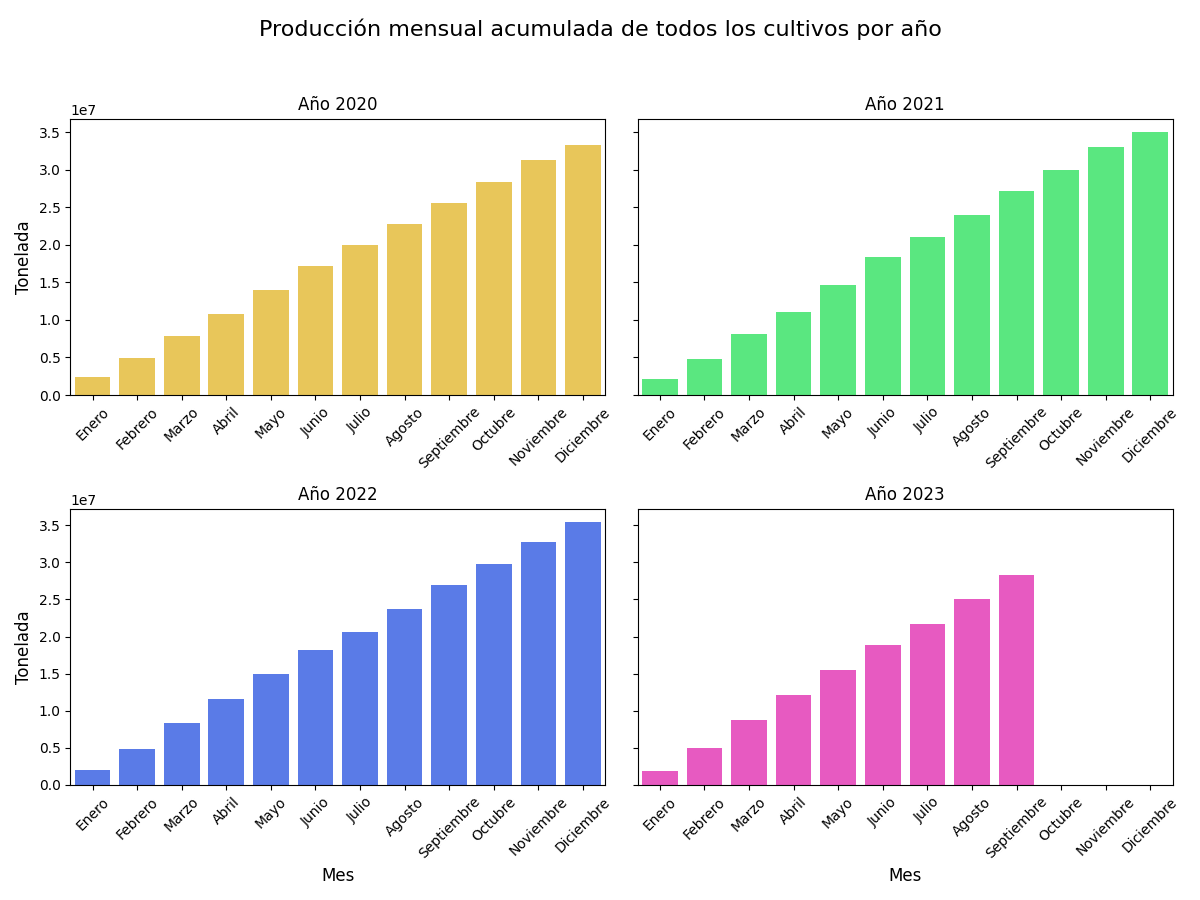

In [19]:
# Crea una figura con una matriz de subgráficas 3x2
fig, axes = plt.subplots(2, 2, figsize=(12, 9), sharey='row')
fig.suptitle('Producción mensual acumulada de todos los cultivos por año', fontsize=16)

i=0

# Itera a través de los años y crea una subgráfica para cada uno
for year in prod_año_mes.index.get_level_values('Anio').unique():
    row, col = i // 2, i % 2  # Calcula la fila y la columna actual en la matriz de subgráficas
    ax = axes[row, col]  # Selecciona la subgráfica actual
    
    # Filtra los datos para el año actual y reordena los meses cronológicamente
    df_year = prod_año_mes.loc[year].reindex(meses_cronologico)
    
    # Crea un gráfico de barras en la subgráfica actual
    sns.barplot(x=df_year.index, y=df_year.values, ci=None, ax=ax, color=colores[i])
    
    # Personaliza la subgráfica
    ax.set_title(f'Año {year}')
    
    # Agrega etiquetas en el eje Y solo a las gráficas de la izquierda
    if col == 0:
        ax.set_ylabel('Tonelada', fontsize=12)

    # Agrega etiquetas en el eje X solo a las gráficas de abajo
    if row == 1:
        ax.set_xlabel('Mes', fontsize=12)
    else:
        ax.set_xlabel('', fontsize=12)
    
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)  # Rota las etiquetas del eje X

    i+=1
    
# Ajusta el diseño de las subgráficas
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Muestra la figura
plt.show()

Aunque de manera general parece ser que en todos los años las producción incrementa de manera continua a través de los meses, sería interesante analizar si la producción de cada mes varía entre años distintos. 

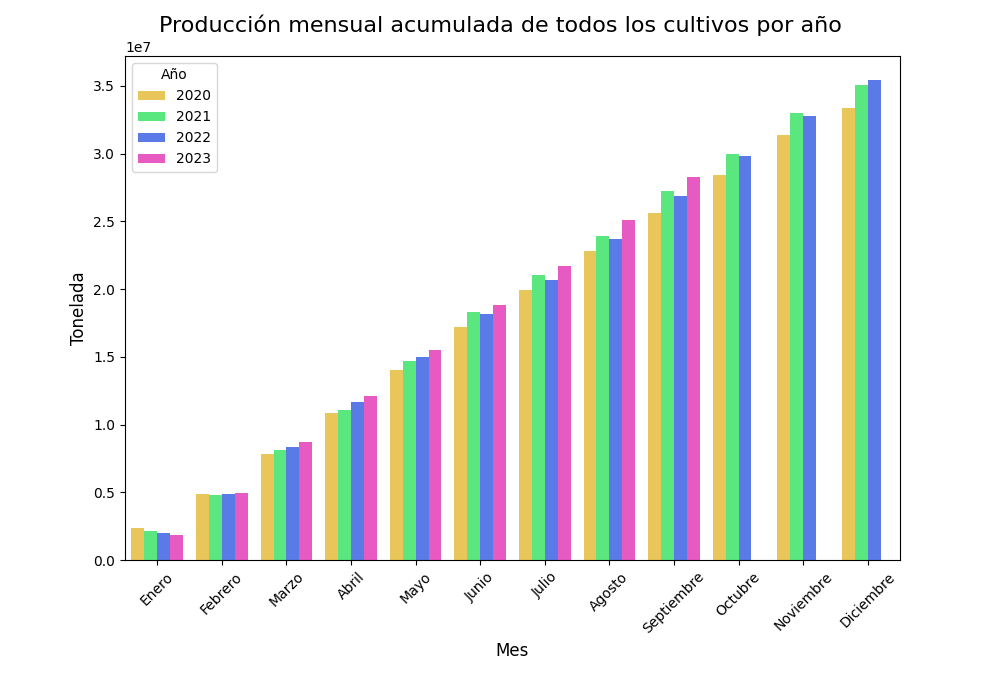

In [20]:
# Reorganiza los datos para que las barras estén en el orden deseado
data = []
# Iteramos en los años
for year in años_unicos:
    df_year = prod_año_mes.loc[year].reindex(meses_cronologico)  # Datos del año de interés
    # Iteramos en los meses ordenados cronológicamente
    for month in meses_cronologico:
        data.append([year, month, df_year[month]])  # Almacenamos valores de producción
# Convertimos arreglo en DataFrame
data = pd.DataFrame(data, columns=['Anio', 'Mes', 'Produccion'])

# Crea una figura
plt.figure(figsize=(10, 7))
plt.suptitle('Producción mensual acumulada de todos los cultivos por año', fontsize=16)

# Crea un gráfico de barras
sns.barplot(data=data, x='Mes', y='Produccion', hue='Anio', palette=['#ffd343', '#42ff75', '#426eff', '#ff42cc'])

# Personaliza la gráfica
plt.ylabel('Tonelada', fontsize=12)
plt.xlabel('Mes', fontsize=12)
plt.xticks(rotation=45)
plt.subplots_adjust(top=0.92, bottom=0.2)  # Ajustar la parte superior para el título

# Añade una leyenda
plt.legend(title='Año')

# Muestra la figura
plt.show()


*Nota: por la naturaleza acumulativa de los datos, para comparar la producción de todo el año, basta con comparar las barras del mes de diciembre.*

De manera general, aunque minimamente, pareciera que la producción ha presentado un incremento año con año.

 Sin embargo, tal como se expresa en el título de las figuras, esto se cumple si tomamos en cuenta el conjunto de todos los cultivos. Valdría la pena evaluar si este patrón sigue cumpliendose para los distintos cultivos individuales.

In [21]:
# Agrupamos por año, por mes, por cultivo y sumamos la producción en todas las localidades
prod_año_mes_cult_serie = df_siap.groupby(['Anio', 'Mes', 'Cultivo'])['Produccion'].sum()

# Crear DataFrame en el que almacenaremos los resultados del groupby
prod_año_mes_cult = pd.DataFrame(index=prod_año_mes_cult_serie.index, columns=['Produccion'])

# Alamacenar resultados en el nuevo DataFrame
prod_año_mes_cult.loc[prod_año_mes_cult.index, 'Produccion'] = prod_año_mes_cult_serie.values

# Ordenar cronológicamente los meses
prod_año_mes_cult = prod_año_mes_cult.reindex(level='Mes', labels=meses_cronologico)

# Convertir los multindexes en columnas
prod_año_mes_cult = prod_año_mes_cult.reset_index()

# Inspeccionamos el DataFrame
prod_año_mes_cult


,Anio,Mes,Cultivo,Produccion
0,2020,Enero,Berenjena,50678.27
1,2020,Enero,Brócoli,24946.08
2,2020,Enero,Cebolla,54117.52
3,2020,Enero,Chile verde,254457.15
4,2020,Enero,Coliflor,1659.48
...,...,...,...,...
1411,2023,Septiembre,Tomate rojo (jitomate),2107213.94
1412,2023,Septiembre,Tomate verde,546730.03
1413,2023,Septiembre,Toronja (pomelo),382801.06
1414,2023,Septiembre,Uva,450516.75


In [22]:
# Función para actualizar la gráfica
def update_production_plot(cultivo):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
    fig.suptitle(f'Producción mensual acumulativa de {cultivo}', fontsize=16)

    for i, año in enumerate(np.flip(años_unicos)):
        row = i // 2  # Calcular la fila
        col = i % 2   # Calcular la columna
        ax = axes[row, col]
        ax.set_title(f"Año {año}")
        
        # Filtrar el DataFrame por año y cultivo
        filtered_data = prod_año_mes_cult[(prod_año_mes_cult['Anio'] == año) & (prod_año_mes_cult['Cultivo'] == cultivo)]

        # Crear la gráfica de barras para el año y cultivo seleccionados
        sns.barplot(data=filtered_data, x='Mes', y='Produccion', ci=None, ax=ax, color=colores[i])
        
        # Labels de los ejes
        ax.set_ylabel('Tonelada')
        if row == 0:
            ax.set_xlabel('')  # Agregar etiqueta x solo a las subgráficas de abajo
        ax.set_xticklabels(filtered_data['Mes'].unique(), rotation=45)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)  # Ajustar la parte superior para el título
    plt.show()

# Asegúrate de tener suficientes años únicos para llenar los 4 subplots
if len(años_unicos) < 4:
    print("No hay suficientes años únicos para llenar los 4 subplots.")
else:
    # Crear widget para seleccionar el cultivo
    cultivo_selector = widgets.Dropdown(options=cultivos_unicos, description='Cultivo:')

    # Widget interactivo para actualizar la gráfica
    widgets.interact(update_production_plot, cultivo=cultivo_selector)


interactive(children=(Dropdown(description='Cultivo:', options=('Berenjena', 'Brócoli', 'Calabacita', 'Cebolla…

Notamos, aunque la evolución en la producción a lo largo del año no es igual para los distintos cultivos, podemos darnos cuenta de que el patrón acumulativo se mantiene para todos los cultivos. 

Tal como en el caso anterior, sería interesante evaluar si la producción en los distintos meses de cada cultivo ha variado a lo largo de los últimos años. 

In [23]:
# Función para actualizar la gráfica
def update_production_plot(cultivo):
    fig.suptitle(f'Producción mensual acumulativa de {cultivo}', fontsize=16)

    # Filtrar el DataFrame por año y cultivo
    filtered_data = prod_año_mes_cult[prod_año_mes_cult['Cultivo'] == cultivo]
    
    # Reorganiza los datos para que las barras estén en el orden deseado
    data = []
    # Iteramos en los años
    for year in años_unicos:
        df_year = filtered_data[filtered_data['Anio'] == year]  # Datos del año de interés
        # Iteramos en los meses ordenados cronológicamente
        for month in meses_cronologico:  
            row = df_year[df_year['Mes'] == month]  # Fila con el mes de interés
            # Evaluar si la fila está vacía
            if not row.empty:                      
                produccion = row['Produccion'].values[0]  # Si no lo está, extraemos el valor de producción
            else:
                produccion = 0  # O un valor predeterminado si no se encuentra un registro
            data.append([year, month, produccion])
    
    # Convertir arreglo en DataFrame
    data = pd.DataFrame(data, columns=['Anio', 'Mes', 'Produccion'])

    # Crea una figura
    plt.figure(figsize=(10, 7))
    plt.suptitle('Producción mensual acumulada de todos los cultivos por año', fontsize=16)

    # Crea un gráfico de barras
    sns.barplot(data=data, x='Mes', y='Produccion', hue='Anio', palette=colores)

    # Personaliza la gráfica
    plt.ylabel('Tonelada', fontsize=12)
    plt.xlabel('Mes', fontsize=12)
    plt.xticks(rotation=45)
    plt.subplots_adjust(top=0.92, bottom=0.2)  # Ajustar la parte superior para el título

    # Añade una leyenda
    plt.legend(title='Año')

    # Muestra la figura
    plt.show()

# Asegúrate de tener suficientes años únicos para llenar los 4 subplots
if len(años_unicos) < 4:
    print("No hay suficientes años únicos para llenar los 4 subplots.")
else:
    # Crear widget para seleccionar el cultivo
    cultivo_selector = widgets.Dropdown(options=cultivos_unicos, description='Cultivo:')

    # Widget interactivo para actualizar la gráfica
    widgets.interact(update_production_plot, cultivo=cultivo_selector)


interactive(children=(Dropdown(description='Cultivo:', options=('Berenjena', 'Brócoli', 'Calabacita', 'Cebolla…

*Nota: por la naturaleza acumulativa de los datos, para comparar la producción de todo el año, basta con comparar las barras del mes de diciembre.*

Parece que sí existe variación en la producción de un mismo mes en distintos años. No obstante, no se observa una tendencia clara, ya que en ocasiones la producción de años previos supera a la de años más recientes, mientras que en otras ocasiones ocurre lo contrario.

**Producción mensual no acumulada**

Para observar la verdadera producción de cada mes, calculamos la producción de cada mes, menos la producción de todos los meses previos.

In [24]:
# Crear DataFrame en el que almacenaremos la producción mensual no acumulativa
prod_año_mes_cult_diff = pd.DataFrame(columns=prod_año_mes_cult.columns)

# Iteramos por año
for año in años_unicos[::-1]:

    # Iteramos por cultivo
    for cultivo in cultivos_unicos:

        # Datos del año y cultivo en turno
        df_year_cult = prod_año_mes_cult[(prod_año_mes_cult['Anio'] == año) & (prod_año_mes_cult['Cultivo'] == cultivo)]

        # Resta de producción de meses previos
        df_year_cult['Produccion'] = df_year_cult['Produccion'].diff().fillna(df_year_cult['Produccion'])

        # Alamacenar resultados en el nuevo DataFrame
        prod_año_mes_cult_diff = pd.concat([prod_año_mes_cult_diff, df_year_cult], axis=0)

# Convertimos los multi-índices del DataFrame en columnas
prod_año_mes_cult_diff.reset_index(drop=True)

,Anio,Mes,Cultivo,Produccion
0,2020,Enero,Berenjena,50678.27
1,2020,Febrero,Berenjena,17995.57
2,2020,Marzo,Berenjena,1315.49
3,2020,Abril,Berenjena,6362.60
4,2020,Mayo,Berenjena,33333.69
...,...,...,...,...
1411,2023,Mayo,Zarzamora,32125.18
1412,2023,Junio,Zarzamora,17753.83
1413,2023,Julio,Zarzamora,9348.42
1414,2023,Agosto,Zarzamora,4660.03


In [25]:
# Calcular la producción promedio de todos los cultivos en cada mes
prod_promedio_todos_cultivos = prod_año_mes_cult_diff.groupby(['Anio', 'Mes'])['Produccion'].mean().reset_index()

# Función para actualizar la gráfica
def update_production_plot(cultivo):
    if cultivo == "Todos los cultivos":
        data = prod_promedio_todos_cultivos
        title = 'Producción mensual de Todos los cultivos'
    else:
        data = prod_año_mes_cult_diff[(prod_año_mes_cult_diff['Cultivo'] == cultivo)]
        title = f'Producción mensual de {cultivo}'
    
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
    fig.suptitle(title, fontsize=16)

    for i, año in enumerate(np.flip(años_unicos)):
        row = i // 2  # Calcular la fila
        col = i % 2   # Calcular la columna
        ax = axes[row, col]
        ax.set_title(f"Año {año}")
        
        # Filtrar el DataFrame por año
        filtered_data = data[data['Anio'] == año]

        # Ordenar por meses de manera cronológica
        meses_categoricos = pd.Categorical(filtered_data['Mes'], categories=meses_cronologico, ordered=True)
        filtered_data = filtered_data.assign(Mes=meses_categoricos).sort_values(by='Mes')

        sns.lineplot(data=filtered_data, x='Mes', y='Produccion', ci=None, ax=ax, color=colores[i])
        
        ax.set_ylabel('Tonelada')
        if row == 0:
            ax.set_xlabel('')
        if col == 1:
            ax.set_ylabel('')
        ax.set_xticklabels(filtered_data['Mes'], rotation=45)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

# Asegúrate de tener suficientes años únicos para llenar los 4 subplots
if len(años_unicos) < 4:
    print("No hay suficientes años únicos para llenar los 4 subplots.")
else:
    # Agregar "Todos los cultivos" a la lista de opciones
    widget_cultivos = cultivos_unicos.copy()
    widget_cultivos.append('Todos los cultivos')
    cultivo_selector = widgets.Dropdown(options=widget_cultivos, description='Cultivo:')

    # Widget interactivo para actualizar la gráfica
    widgets.interact(update_production_plot, cultivo=cultivo_selector)


interactive(children=(Dropdown(description='Cultivo:', options=('Berenjena', 'Brócoli', 'Calabacita', 'Cebolla…

Observamos un patrón menos claro en cuanto a la cantidad de producción que hay cada mes. Aun así, tal como en los casos anteriores, sería interesante evaluar si estos patrones de producción han cambiado a lo largo de los últimos años. 

In [26]:
# Calcular el promedio de producción de todos los cultivos en cada mes
prod_promedio_todos_cultivos = prod_año_mes_cult_diff.groupby(['Anio', 'Mes'])['Produccion'].mean().reset_index()

# Ordenar cronológicamente por meses
# Convierte la columna 'Mes' en una categoría ordenada
prod_promedio_todos_cultivos['Mes'] = pd.Categorical(prod_promedio_todos_cultivos['Mes'], categories=meses_cronologico, ordered=True)

# Ordena el DataFrame por la columna categórica 'Mes'
prod_promedio_todos_cultivos = prod_promedio_todos_cultivos.sort_values(by='Mes')

# Función para actualizar la gráfica
def update_production_plot(cultivo):
    if cultivo == "Todos los cultivos":
        data = prod_promedio_todos_cultivos
        title = 'Producción mensual promedio de todos los cultivos'
    else:
        filtered_data = prod_año_mes_cult_diff[prod_año_mes_cult_diff['Cultivo'] == cultivo]
        data = []
        for year in años_unicos:
            df_year = filtered_data[filtered_data['Anio'] == year]
            for month in meses_cronologico:
                row = df_year[df_year['Mes'] == month]
                if not row.empty:
                    produccion = row['Produccion'].values[0]
                else:
                    produccion = 0
                data.append([year, month, produccion])
        data = pd.DataFrame(data, columns=['Anio', 'Mes', 'Produccion'])
        title = f'Producción mensual de {cultivo}'
    
    plt.figure(figsize=(10, 7))
    plt.suptitle(title, fontsize=16)
    
    sns.barplot(data=data, x='Mes', y='Produccion', hue='Anio', palette=colores)
    
    plt.ylabel('Tonelada', fontsize=12)
    plt.xlabel('Mes', fontsize=12)
    plt.xticks(rotation=45)
    plt.subplots_adjust(top=0.92, bottom=0.2)
    
    plt.legend(title='Año')
    
    plt.show()

# Asegúrate de tener suficientes años únicos para llenar los 4 subplots
if len(años_unicos) < 4:
    print("No hay suficientes años únicos para llenar los 4 subplots.")
else:
    # Agregar "Todos los cultivos" a la lista de opciones
    widget_cultivos = cultivos_unicos.copy()
    widget_cultivos.append('Todos los cultivos')
    cultivo_selector = widgets.Dropdown(options=widget_cultivos, description='Cultivo:')
    
    # Widget interactivo para actualizar la gráfica
    widgets.interact(update_production_plot, cultivo=cultivo_selector)


interactive(children=(Dropdown(description='Cultivo:', options=('Berenjena', 'Brócoli', 'Calabacita', 'Cebolla…

Para identificar cuáles son los meses con mayor producción, podemos promediar la producción de cada cultivo a lo largo de los útlmos años.  

In [27]:
# Función para actualizar la gráfica para un cultivo seleccionado
def update_production_plot(cultivo):

    if cultivo == "Todos los cultivos":

        # Promediamos la producción de todos los cultivos
        data_cultivo = prod_año_mes_cult_diff.groupby(['Anio', 'Mes'])['Produccion'].mean().reset_index()
    
    else:

        # Filtrar los datos para el cultivo seleccionado
        data_cultivo = prod_año_mes_cult_diff[prod_año_mes_cult_diff['Cultivo'] == cultivo]
    
    # Asegúrate de que la columna 'Produccion' sea numérica
    data_cultivo['Produccion'] = pd.to_numeric(data_cultivo['Produccion'], errors='coerce')

    # Calcular la producción total de cada mes a lo largo de los 4 años
    produccion_total_por_mes = data_cultivo.groupby('Mes')['Produccion'].mean()
    
    # Encontrar los 3 meses con la producción más alta y el mes con la producción más baja
    meses_top3 = produccion_total_por_mes.nlargest(12).index[::-1]
    #mes_baja = produccion_total_por_mes.idxmin()

    # Guardar valores de producción de cada barra
    producciones = produccion_total_por_mes.nlargest(12).round(2).tolist()[::-1]
    #producciones.append(round(produccion_total_por_mes.min(), 2))
    #producciones = producciones[::-1]

    # Crear una gráfica de barras horizontales sin bordes
    plt.figure(figsize=(10, 8))
    #plt.barh(mes_baja, produccion_total_por_mes[mes_baja], label='Mes con menor producción', color='red', edgecolor='none')
    plt.barh(meses_top3, produccion_total_por_mes[meses_top3], color='green', edgecolor='none')
    plt.ylabel('Mes')
    plt.xlabel('Producción')
    plt.title(f'Meses con mayor y menor producción promedio en los últimos 4 años - Cultivo: {cultivo}')
    #plt.legend()
    #plt.axvline(color='red', x=np.mean(producciones))
    plt.gca().spines['left'].set_visible(False)  # Eliminar el borde izquierdo
    plt.gca().spines['top'].set_visible(False)   # Eliminar el borde superior
    plt.gca().spines['right'].set_visible(False) # Eliminar el borde derecho
    plt.gca().spines['bottom'].set_visible(False) # Eliminar el borde inferior
    plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    
    for i, v in enumerate(producciones):
        plt.text(v + 500, i, str(v), color='black', fontweight='bold', ha='left')
        #plt.text(np.mean(producciones) - 4000, -1.5, str(np.mean(producciones)), color='black', fontweight='bold', ha='left')

    plt.show()

# Agregar "Todos los cultivos" a la lista de opciones
widget_cultivos = cultivos_unicos.copy()
widget_cultivos.append('Todos los cultivos')
# Crear widget para seleccionar el cultivo
cultivo_selector = widgets.Dropdown(options=widget_cultivos, description='Cultivo:')

# Widget interactivo para actualizar la gráfica
widgets.interact(update_production_plot, cultivo=cultivo_selector)


interactive(children=(Dropdown(description='Cultivo:', options=('Berenjena', 'Brócoli', 'Calabacita', 'Cebolla…

<function __main__.update_production_plot(cultivo)>

### 2. ¿En qué localidades hay mayor probabilidad de acumulación de excedentes?

**Producción anual por estado**

*Retomando el hecho de que el SIAP arroja la producción de manera acumulativa, para saber la producción que hubo en un año particular basta con extraer la producción asociada al mes de diciembre de dicho año*

In [28]:
# Agrupamos por año y por cultivo, y sumamos la produccion
prod_año_estado = df_siap[df_siap['Mes'] == 'Diciembre'].groupby(['Anio', 'Entidad'])['Produccion'].sum()
prod_año_estado

Anio  Entidad            
2020  Aguascalientes          351664.26
      Baja California         481237.33
      Baja California Sur     422417.96
      Campeche                169610.55
      Chiapas                1435511.96
                                ...    
2022  Tamaulipas             1233951.16
      Tlaxcala                 82497.48
      Veracruz               5435710.51
      Yucatán                 388565.36
      Zacatecas              1601359.47
Name: Produccion, Length: 96, dtype: float64

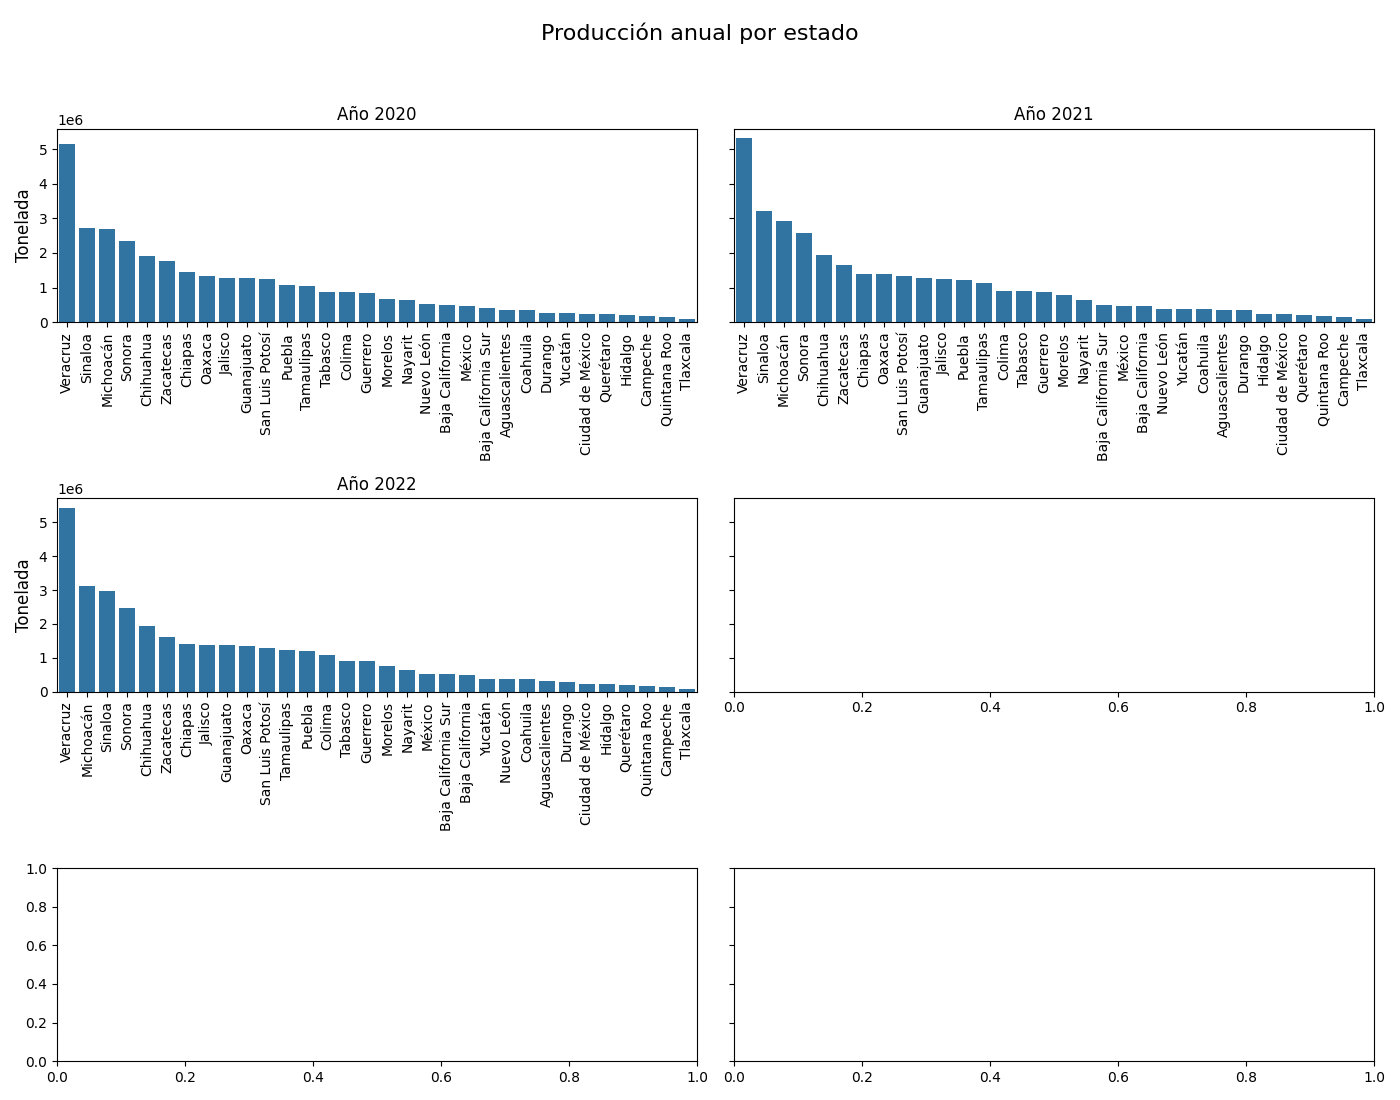

In [29]:
# Crea una figura con una matriz de subgráficas 3x2
fig, axes = plt.subplots(3, 2, figsize=(14, 11), sharey='row')
fig.suptitle('Producción anual por estado', fontsize=16)

i=0

# Itera a través de los años y crea una subgráfica para cada uno
for year in prod_año_estado.index.get_level_values('Anio').unique():
    row, col = i // 2, i % 2  # Calcula la fila y la columna actual en la matriz de subgráficas
    ax = axes[row, col]  # Selecciona la subgráfica actual
    
    # Filtra los datos para el año actual y reordena los meses cronológicamente
    df_year = prod_año_estado.loc[year].sort_values(ascending=False)
    
    # Crea un gráfico de barras en la subgráfica actual
    sns.barplot(x=df_year.index, y=df_year.values, ci=None, ax=ax)
    
    # Personaliza la subgráfica
    ax.set_title(f'Año {year}')
    
    # Agrega etiquetas en el eje Y solo a las gráficas de la izquierda
    if col == 0:
        ax.set_ylabel('Tonelada', fontsize=12)

    # Agrega etiquetas en el eje X solo a las gráficas de abajo
    if row == 2:
        ax.set_xlabel('Estado', fontsize=12)
    else:
        ax.set_xlabel('', fontsize=12)
    
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)  # Rota las etiquetas del eje X

    i+=1
    
# Ajusta el diseño de las subgráficas
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Muestra la figura
plt.show()

**Producción anual por municipio**

In [30]:
# Agrupamos por año y por cultivo, y sumamos la produccion
prod_est_año_mun = df_siap[df_siap['Mes'] == 'Diciembre'].groupby(['Entidad', 'Anio', 'Municipio'])['Produccion'].sum()
prod_est_año_mun

Entidad         Anio  Municipio            
Aguascalientes  2020  Aguascalientes             5428.57
                      Asientos                 129434.19
                      Calvillo                 128973.26
                      Cosío                     18900.45
                      El Llano                   1080.37
                                                 ...    
Zacatecas       2022  Villa González Ortega      6919.51
                      Villa Hidalgo             27454.74
                      Villa de Cos             176253.53
                      Villanueva                13626.20
                      Zacatecas                 12386.20
Name: Produccion, Length: 6824, dtype: float64

In [31]:
# Función para crear gráfica dinámica
def update_bar_plot(entidad, año):
    plt.figure(figsize=(10, 6))
    
    if año == "Todos los años":
        # Calcular el promedio de producción de cada municipio en todos los años
        average_data = prod_est_año_mun.xs(entidad, level='Entidad').groupby('Municipio').mean()
        average_data = average_data.sort_values(ascending=False).head(50)
        
        # Crear la gráfica de barras
        sns.barplot(x=average_data.index, y=average_data.values, ci=None)
        plt.title(f'Producción promedio en {entidad} - Todos los años')
    else:
        # Filtrar el DataFrame por entidad y año
        filtered_data = prod_est_año_mun.xs((entidad, int(año)), level=('Entidad', 'Anio'))
        
        # Reindexar los datos para que los municipios estén en el eje x
        df_filtered = filtered_data.reset_index()
        
        # Ordenar los municipios en función de la producción descendente
        df_filtered = df_filtered.sort_values(by='Produccion', ascending=False)
        
        # Limitar a los primeros 50 municipios
        df_filtered = df_filtered.head(50)
        
        # Crear la gráfica de barras
        sns.barplot(data=df_filtered, x='Municipio', y='Produccion', ci=None)
        plt.title(f'Producción en {entidad} - Año {año}')
    
    plt.xlabel('Municipio')
    plt.ylabel('Toneladas')
    plt.xticks(rotation=90)
    plt.subplots_adjust(top=0.95, bottom=0.5)
    plt.show()

# Obtener la lista de entidades y años únicos
entidades_unicas = df_siap['Entidad'].unique()
años_unicos = prod_est_año_mun.index.get_level_values('Anio').unique()

# Convertir los valores de años en cadenas de texto
años_unicos = [str(a) for a in años_unicos]

# Agregar la opción "Todos los años" a la lista de años
años_unicos = ["Todos los años"] + años_unicos

# Crear widgets para seleccionar entidad y año
entidad_selector = widgets.Dropdown(options=entidades_unicas, description='Entidad:')
año_selector = widgets.Dropdown(options=años_unicos, description='Año:')

# Widget interactivo para actualizar la gráfica
widgets.interact(update_bar_plot, entidad=entidad_selector, año=año_selector)


interactive(children=(Dropdown(description='Entidad:', options=('Baja California Sur', 'Morelos', 'Nayarit', '…

<function __main__.update_bar_plot(entidad, año)>

### 3. ¿Qué cultivos tienen mayor tendencia a ser producidos excesivamente?

**Producción anual por cultivo**

In [34]:
# Agrupamos por año y por cultivo, y sumamos la produccion
prod_año_cult = df_siap[df_siap['Mes'] == 'Diciembre'].groupby(['Anio', 'Cultivo'])['Produccion'].sum()
prod_año_cult

Anio  Cultivo               
2020  Berenjena                  113964.03
      Brócoli                    582665.42
      Cebolla                   1447856.57
      Chile verde               3027855.06
      Coliflor                   102440.94
                                   ...    
2022  Tomate rojo (jitomate)    3185507.70
      Tomate verde               735863.50
      Toronja (pomelo)           489100.97
      Uva                        477318.60
      Zarzamora                  222623.05
Name: Produccion, Length: 94, dtype: float64

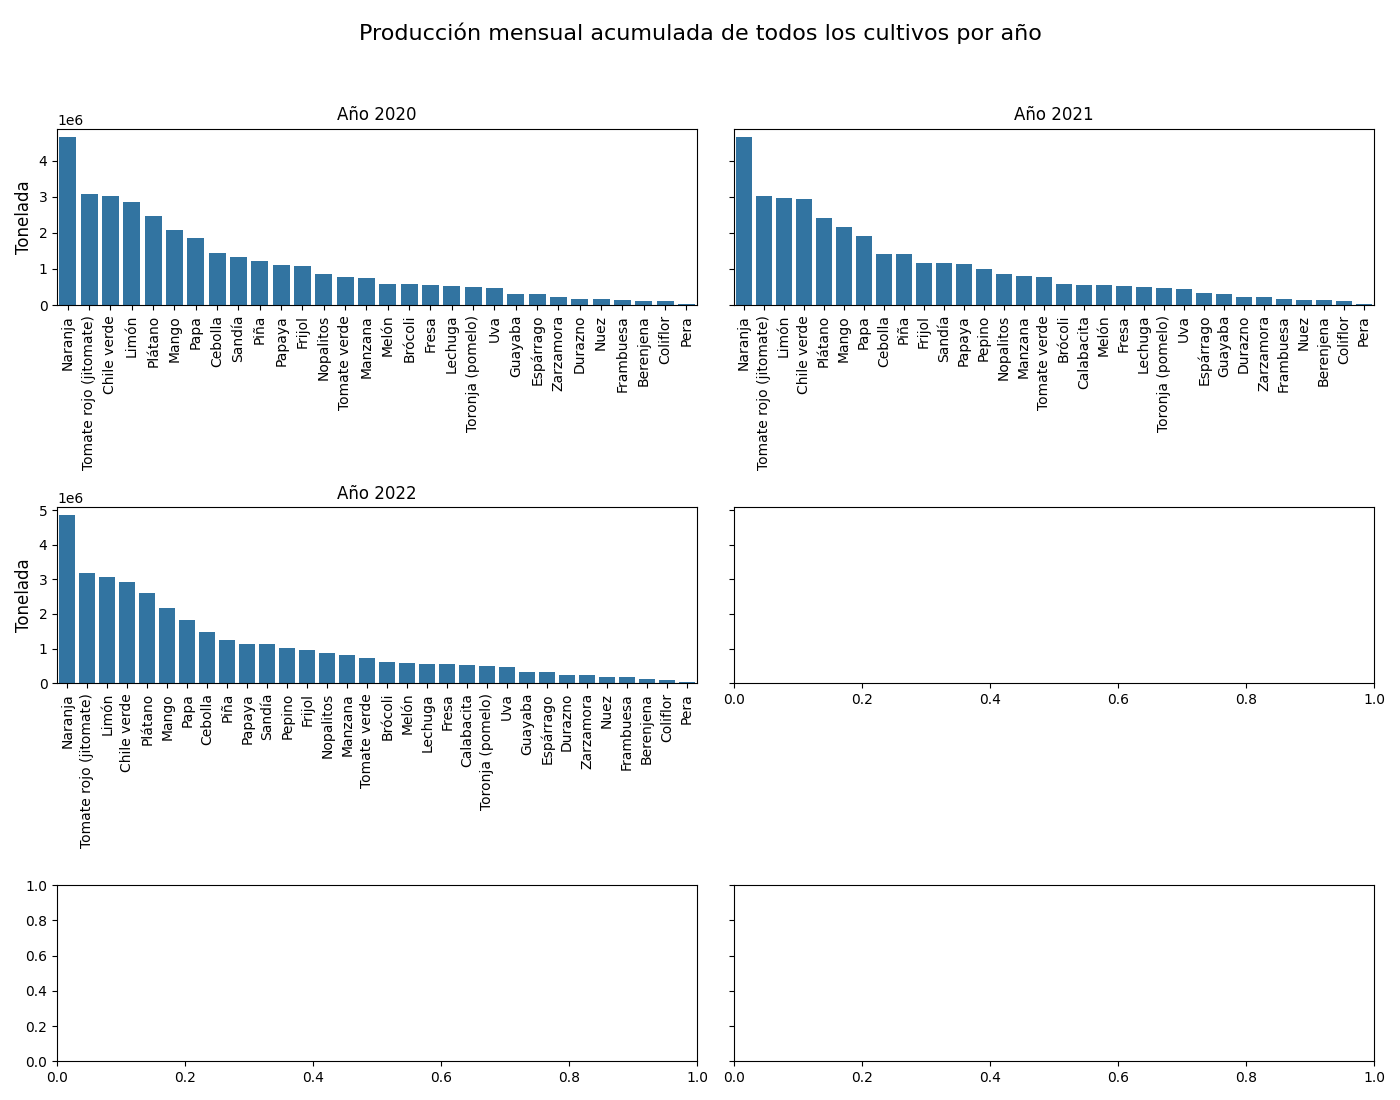

In [35]:
# Crea una figura con una matriz de subgráficas 3x2
fig, axes = plt.subplots(3, 2, figsize=(14, 11), sharey='row')
fig.suptitle('Producción mensual acumulada de todos los cultivos por año', fontsize=16)

i=0

# Itera a través de los años y crea una subgráfica para cada uno
for year in prod_año_cult.index.get_level_values('Anio').unique():
    row, col = i // 2, i % 2  # Calcula la fila y la columna actual en la matriz de subgráficas
    ax = axes[row, col]  # Selecciona la subgráfica actual
    
    # Filtra los datos para el año actual y reordena los meses cronológicamente
    df_year = prod_año_cult.loc[year].sort_values(ascending=False)
    
    # Crea un gráfico de barras en la subgráfica actual
    sns.barplot(x=df_year.index, y=df_year.values, ci=None, ax=ax)
    
    # Personaliza la subgráfica
    ax.set_title(f'Año {year}')
    
    # Agrega etiquetas en el eje Y solo a las gráficas de la izquierda
    if col == 0:
        ax.set_ylabel('Tonelada', fontsize=12)

    # Agrega etiquetas en el eje X solo a las gráficas de abajo
    if row == 2:
        ax.set_xlabel('Cultivo', fontsize=12)
    else:
        ax.set_xlabel('', fontsize=12)
    
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)  # Rota las etiquetas del eje X

    i+=1
    
# Ajusta el diseño de las subgráficas
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Muestra la figura
plt.show()

## SNIIM

### Cargamos los datos tidy

In [36]:
# Path al archivo parquet
url_sniim = r'C:\Users\jcbar\OneDrive\Documentos\Ingeniería de Características\Proyecto\Primera parte\Tidy\SNIIM.parquet'
# Cargar archivo parquet como DataFrame
df_sniim = pd.read_parquet(url_sniim)
# Inspeccionar primeros elementos del DataFrame
df_sniim.head()

,Fecha,Presentacion,Origen,Destino,Precio Minimo,Precio Maximo,Precio Frecuente,Observacion,Cultivo
0,02/01/2018,Rollo,Puebla,"Baja California : Central de Abasto INDIA, Tij...",16.0,16.0,16.0,Rollo de 2k,acelga_primera
1,03/01/2018,Rollo,Puebla,"Baja California : Central de Abasto INDIA, Tij...",16.0,16.0,16.0,Rollo de 2k,acelga_primera
2,04/01/2018,Rollo,Puebla,"Baja California : Central de Abasto INDIA, Tij...",16.0,16.0,16.0,Rollo de 2k,acelga_primera
3,05/01/2018,Rollo,Puebla,"Baja California : Central de Abasto INDIA, Tij...",16.0,16.0,16.0,Rollo de 2k,acelga_primera
4,08/01/2018,Rollo,Puebla,"Baja California : Central de Abasto INDIA, Tij...",16.0,16.0,16.0,nan,acelga_primera


In [37]:
# Cambiar el nombre de las columnas al mismo formato que utilizan los datos del SIAP 
df_sniim = df_sniim.rename(columns={'Precio_min':'Precio Minimo', 'Precio_max':'Precio Maximo', 'precio_frec':'Precio Frecuente'})
# Inspeccionar primeros elementos del DataFrame
df_sniim.head()

,Fecha,Presentacion,Origen,Destino,Precio Minimo,Precio Maximo,Precio Frecuente,Observacion,Cultivo
0,02/01/2018,Rollo,Puebla,"Baja California : Central de Abasto INDIA, Tij...",16.0,16.0,16.0,Rollo de 2k,acelga_primera
1,03/01/2018,Rollo,Puebla,"Baja California : Central de Abasto INDIA, Tij...",16.0,16.0,16.0,Rollo de 2k,acelga_primera
2,04/01/2018,Rollo,Puebla,"Baja California : Central de Abasto INDIA, Tij...",16.0,16.0,16.0,Rollo de 2k,acelga_primera
3,05/01/2018,Rollo,Puebla,"Baja California : Central de Abasto INDIA, Tij...",16.0,16.0,16.0,Rollo de 2k,acelga_primera
4,08/01/2018,Rollo,Puebla,"Baja California : Central de Abasto INDIA, Tij...",16.0,16.0,16.0,nan,acelga_primera


### Dimensiones de nuestros datos

In [38]:
# Dimensión de nuestros datos
print(f"Dimensión de los datos: {df_sniim.shape}")

Dimensión de los datos: (900763, 9)


### Tipo de dato de cada variable

In [39]:
# Tipo de dato de cada variable
print(f"Tipo de dato de cada variable:\n {df_sniim.dtypes}\n")

Tipo de dato de cada variable:
 Fecha                object
Presentacion         object
Origen               object
Destino              object
Precio Minimo       float64
Precio Maximo       float64
Precio Frecuente    float64
Observacion          object
Cultivo              object
dtype: object



Convertimos la variable *Fecha* a *datetime*

In [40]:
# Efectuar conversión especificando el formato específico de la fecha
df_sniim['Fecha'] = pd.to_datetime(df_sniim['Fecha'], format="%d/%m/%Y")
# Inspeccionar nuevamente el tipo de dato de cada variable
print(f"Tipo de dato de cada variable:\n {df_sniim.dtypes}\n")

Tipo de dato de cada variable:
 Fecha               datetime64[ns]
Presentacion                object
Origen                      object
Destino                     object
Precio Minimo              float64
Precio Maximo              float64
Precio Frecuente           float64
Observacion                 object
Cultivo                     object
dtype: object



In [41]:
#Filtramos nuestro DataFrame solo para los años 2020 - 2023 
df_sniim = df_sniim[df_sniim['Fecha'].dt.year >= 2020]

In [42]:
# Dimensión de nuestros datos
print(f"Dimensión de los datos: {df_sniim.shape}")

Dimensión de los datos: (593710, 9)


### Estadísticos descriptivos de nuestros datos

In [43]:
# Estadísticos descriptivos ignorando la columna Anio
df_sniim.loc[:, df_sniim.columns != 'Fecha'].describe().applymap('{:,.2f}'.format)

,Precio Minimo,Precio Maximo,Precio Frecuente
count,"593,710.00","593,710.00","593,710.00"
mean,32.42,36.21,34.52
std,35.98,39.17,37.45
min,0.25,0.35,0.00
25%,12.00,13.89,13.00
50%,19.00,22.00,20.00
75%,38.00,42.00,40.00
max,400.00,"3,030.00",400.00


### Valores faltantes

In [44]:
# Valores faltantes
print(f"Valores faltantes:\n {df_sniim.isna().sum()}")

Valores faltantes:
 Fecha               0
Presentacion        0
Origen              0
Destino             0
Precio Minimo       0
Precio Maximo       0
Precio Frecuente    0
Observacion         0
Cultivo             0
dtype: int64


### Datos repetidos

In [45]:
# Filas repetidas
print(f"Cantidad de filas repetidas: {df_sniim.duplicated().sum()}")

Cantidad de filas repetidas: 0


### Filtrar DataFrame por cultivos de interés

Para esto debemos tomar como referencia la lista de cultivos ofrecida por el experto de la red BAMX.

In [46]:
# Inspeccionamos nuevamente algunos elementos de la lista de cultivos
cultivos[:10]

['Tomate rojo (jitomate)',
 'Chile verde',
 'Limón',
 'Pepino',
 'Plátano',
 'Mango',
 'Garbanzo',
 'Brócoli',
 'Cebolla',
 'Sandía']

Ahora inspeccionamos los cultivos de los datos del SNIIM.

In [47]:
# Inspeccionar algunos nombres de cultivos
df_sniim['Cultivo'].sample(n=10)

328518                       durazno amarillo_primera
848324                              uva globo_primera
679673                                 pepino_primera
105355                           cebolla bola_primera
665231                             papa alpha_primera
331896                       durazno amarillo_primera
56289                                 brócoli_primera
723066    plátano chiapas calidad exportación_primera
709849                            piña grande_primera
877276                             yerbabuena_primera
Name: Cultivo, dtype: object

El formato consiste en el nombre de los cultivos seguido por una descripción de la variedad.
Debido a que en el SIAP no se maneja variedad, para poder homologar los datos nos quedamos solamente con el nombre de los cultivos. No obstante, esto aplica solo para los cultivos cuyo nombre consiste en una sola palabra. Para los nombres con más palabras utilizamos un abordaje manual. 

In [48]:
# Nombres de cultivo con más de una palabra
[cultivo for cultivo in cultivos if len(cultivo.split(' ')) > 1]

['Tomate rojo (jitomate)', 'Chile verde', 'Tomate verde', 'Toronja (pomelo)']

In [49]:
# Creamos una nueva columna en nuestro DataFrame para almacenar los nuevos nombres de los cultivos
df_sniim['Cultivo SIAP'] = df_sniim['Cultivo']

**Tomate rojo (jitomate)**

Reemplazamos los cultivos "tomate bola_primera" y "tomate saladette_primera"

In [50]:
# Seleccionar filas que cumplan con la condición
condicion = df_sniim['Cultivo SIAP'].isin(['tomate bola_primera', 'tomate saladette_primera'])

# Modificar los valores en esas filas
df_sniim.loc[condicion, 'Cultivo SIAP'] = 'Tomate rojo (jitomate)'

**Tomate verde**

Reemplazamos el cultivo "tomate verde_primera"

In [51]:
# Seleccionar filas que cumplan con la condición
condicion = df_sniim['Cultivo SIAP'] == 'tomate verde_primera'

# Modificar los valores en esas filas
df_sniim.loc[condicion, 'Cultivo SIAP'] = 'Tomate verde'

**Toronja (pomelo)**

Reemplazamos el cultivo "toronja blanca_primera", "toronja roja mediana_primera", "toronja roja_primera" y "toronja rosada_primera"

In [52]:
# Seleccionar filas que cumplan con la condición
condicion = df_sniim['Cultivo SIAP'].isin(["toronja blanca_primera", "toronja roja mediana_primera", "toronja roja_primera", "toronja rosada_primera"])

# Modificar los valores en esas filas
df_sniim.loc[condicion, 'Cultivo SIAP'] = 'Toronja (pomelo)'

**Chile verde**

Reemplazamos los cultivos 'chile ancho_primera', 'chile caloro_primera', 'chile caribe_primera', 'chile cat_primera', 'chile guajillo_primera',
       'chile húngaro_primera',
       'chile mirasol_primera',
       'chile puya fresco_primera',
       'chile puya seco_primera'

**'chile pimiento morrón_primera'**
**'chile pasilla_primera'**
**'chile de árbol seco_primera'**
**'chile de árbol fresco_primera'**
**'chile dulce_primera'**

In [53]:
# Seleccionar filas que cumplan con la condición
condicion = df_sniim['Cultivo SIAP'].isin(['chile anaheim_primera', 'chile california_primera', 'chile chilaca_primera', 'chile serrano_primera', 'chile poblano_primera',
                                       'chile jalapeño_primera', 'chile habanero_primera'])

# Modificar los valores en esas filas
df_sniim.loc[condicion, 'Cultivo SIAP'] = 'Chile verde'

**Nopalitos**

Otro cultivo a tomar en cuenta son los Nopalitos que en el SNIIM vienen solamente como Nopal

In [54]:
# Seleccionar filas que cumplan con la condición
condicion = df_sniim['Cultivo SIAP'].isin(['nopal grande_primera', 'nopal_primera'])

# Modificar los valores en esas filas
df_sniim.loc[condicion, 'Cultivo SIAP'] = 'Nopalitos'

Ahora sí reemplazamos los nombres de cultivo conformados por una sola palabra

In [55]:
# Condición para ignorar los cultivos que ya modificamos
condicion = ~df_sniim['Cultivo SIAP'].isin(['Tomate rojo (jitomate)', 'Tomate verde', 'Toronja (pomelo)', 'Nopalitos', 'Chile verde'])

# Expresión regular para capturar la primera palabra
pattern = r'^([^\W_]+)'

# Aplicar la expresión regular para mantener solo la primera palabra
df_sniim.loc[condicion, 'Cultivo SIAP'] = df_sniim[condicion]['Cultivo SIAP'].str.extract(pattern).values

# Reemplazar la primera letra por mayúscula
df_sniim.loc[condicion, 'Cultivo SIAP'] = df_sniim.loc[condicion, 'Cultivo SIAP'].str.title()

# Inspeccionar nuevamente algunos nombres de cultivos
df_sniim['Cultivo SIAP'].sample(n=10)

347485       Ejote
156712       Chile
136637     Chayote
459971     Lechuga
838400         Uva
386435       Fresa
558342     Manzana
262115    Chícharo
338657       Ejote
424226      Jícama
Name: Cultivo SIAP, dtype: object

Utilizamos nuevamente la lista de cultivos para filtrar el DataFrame

In [56]:
# Filtramos el DataFrame para quedarnos solo con los cultivos de interés
df_sniim = df_sniim[df_sniim['Cultivo SIAP'].isin(cultivos)]

# Dimensión de nuestros datos
print(f"Dimensión de los datos: {df_sniim.shape}")

Dimensión de los datos: (334540, 10)


In [57]:
# Inspeccionamos el DataFrame
df_sniim.sample(n=5)

,Fecha,Presentacion,Origen,Destino,Precio Minimo,Precio Maximo,Precio Frecuente,Observacion,Cultivo,Cultivo SIAP
457201,2021-02-04,Pieza,Aguascalientes,Aguascalientes: Centro Comercial Agropecuario ...,5.00,7.0,6.0,nan,lechuga romanita sin clasificación_primera,Lechuga
899323,2022-03-23,Caja de 4 kg.,Michoacán,Michoacán: Mercado de Abasto de Morelia,18.75,25.0,25.0,nan,zarzamora_primera,Zarzamora
639046,2021-09-07,Kilogramo,Nayarit,Nayarit: Nayarabastos de Tepic,183.00,185.0,184.0,nan,nuez cáscara de papel_primera,Nuez
628536,2021-12-24,Kilogramo,Baja California Sur,Baja California Sur: Unión de Comerciantes de ...,15.00,17.0,15.0,nan,nopal grande_primera,Nopalitos
57917,2022-11-15,Kilogramo,Distrito Federal,"Campeche: Mercado ""Pedro Sáinz de Baranda"", Ca...",20.00,25.0,25.0,nan,brócoli_primera,Brócoli


In [58]:
print(f"Cantidad de cultivos de Everardo: {len(cultivos)}")

x = 0 
for cultivo in df_sniim['Cultivo SIAP'].unique():
    if cultivo in cultivos:
        x+=1

print(f"Cantidad de cultivos del sniim que están en cultivos de Everardo: {x}")

Cantidad de cultivos de Everardo: 33
Cantidad de cultivos del sniim que están en cultivos de Everardo: 30


In [59]:
print(f"Cultivos de Everardo que no están en los del sniim: \n")

for cultivo in cultivos:
    if cultivo not in df_sniim['Cultivo SIAP'].unique():
        print(cultivo)

Cultivos de Everardo que no están en los del sniim: 

Garbanzo
Frambuesa
Frijol


### 1. ¿Existe una tendencia clara en la evolución de los precios a lo largo de los 4 años analizados? ¿Estos han incrementado o disminuido?

Debido a la manipulación que realizamos con los cultivos del SNIIM para homologarlos con los del SIAP, es posible que un mismo cultivo presente distintos precios para una misma fecha. Para abordar esto, identificamos los casos en los que estos sucede y promediamos los precios asociados a una misma fecha.

In [60]:
# Agrupar por Fecha y por Cultivo SIAP
prec_fecha_cult = df_sniim.groupby(['Fecha', 'Cultivo SIAP'])['Precio Frecuente'].mean().reset_index()
prec_fecha_cult

,Fecha,Cultivo SIAP,Precio Frecuente
0,2020-01-02,Berenjena,20.766000
1,2020-01-02,Brócoli,18.951667
2,2020-01-02,Calabacita,12.190714
3,2020-01-02,Cebolla,16.702692
4,2020-01-02,Chile verde,35.347222
...,...,...,...
27985,2023-10-25,Tomate rojo (jitomate),19.731429
27986,2023-10-25,Tomate verde,12.646667
27987,2023-10-25,Toronja (pomelo),18.988571
27988,2023-10-25,Uva,66.713704


In [61]:
# Crear una función para generar la gráfica
def plot_price_by_cultivo_siap(cultivo_seleccionado):
    if cultivo_seleccionado == 'Todos los cultivos':
        # Graficar precio promedio de todos los cultivos
        df_all_cultivos = prec_fecha_cult.groupby('Fecha')['Precio Frecuente'].mean().reset_index()
        plt.figure(figsize=(12, 6))
        for i, (year, group) in enumerate(df_all_cultivos.groupby(df_all_cultivos['Fecha'].dt.year)):
            sns.lineplot(x=group['Fecha'], y=group['Precio Frecuente'], linestyle='-', label=f'Año {year}', color=colores[i])
    else:
        # Graficar precio por cultivo seleccionado
        df_filtered = prec_fecha_cult[prec_fecha_cult['Cultivo SIAP'] == cultivo_seleccionado]
        plt.figure(figsize=(12, 6))
        for i, (year, group) in enumerate(df_filtered.groupby(df_filtered['Fecha'].dt.year)):
            sns.lineplot(x=group['Fecha'], y=group['Precio Frecuente'], linestyle='-', label=f'Año {year}', color=colores[i])

    plt.title(f'Precio Frecuente de {cultivo_seleccionado}', pad=15)
    plt.xlabel('Fecha', labelpad=20)
    plt.ylabel('Precio Frecuente', labelpad=15)
    plt.xticks(rotation=45)
    plt.subplots_adjust(bottom=0.2)
    plt.tight_layout()  # Ajusta automáticamente las posiciones de los elementos para evitar solapamientos
    plt.legend()  # Mostrar leyenda con los años
    # Fijar el rango del eje x
    plt.xlim(pd.Timestamp('2020-01-01'), pd.Timestamp('2023-10-26'))
    plt.show()

# Obtener la lista de cultivos únicos (Cultivo SIAP)
cultivos_siap_unicos = df_sniim['Cultivo SIAP'].unique()

# Agregar la opción "Todos los cultivos" a la lista
opciones_cultivos = list(cultivos_siap_unicos) + ['Todos los cultivos']

# Crear un widget para seleccionar el cultivo SIAP
cultivo_selector = widgets.Dropdown(
    options=opciones_cultivos,
    description='Cultivo SIAP:',
    disabled=False
)

# Crear la interfaz interactiva
interact(plot_price_by_cultivo_siap, cultivo_seleccionado=cultivo_selector)


interactive(children=(Dropdown(description='Cultivo SIAP:', options=('Berenjena', 'Brócoli', 'Calabacita', 'Ce…

<function __main__.plot_price_by_cultivo_siap(cultivo_seleccionado)>

A pesar de que cada cultivo presenta un curso en la evolución de sus precios muy particular, la gran mayoría muestra una tendencia general al incremento a lo largo del tiempo. Mientras que esto puede explicarse simplemente por los fenómenos de inflación, la causa de las fluctuaciones particulares de cada cultivo están fuera del alcance del presente análisis.  

### 2. ¿Cómo es este patrón para los mercados de los distintos estados?

Para evaluar la evolución de los precios de los cultivos en los distintos mercados, primero realizamos una agrupación con base en los estados proveedores. Esto permitirá más adelante evaluar la relación que existe entre la producción de estos estados, y los precios en sus mercados de destino.  

Como primer paso para llevar a cabo esta agrupación es necesario homologar el nombre de los estados en ambos DataFrames. 

In [62]:
# Evaluamos qué nombres de estado en el sniim no están en el siap
print('Estados del SNIIM no presentes en el SIAP:\n')
for estado_sniim in df_sniim['Origen'].unique():
    if estado_sniim not in df_siap['Entidad'].unique():
        print(estado_sniim)

Estados del SNIIM no presentes en el SIAP:

Distrito Federal
Importación
Nacional


In [63]:
# En los datos del SNIIM reemplazamos Distrito Federal por Ciudad de México
condicion = df_sniim['Origen'] == "Distrito Federal"
df_sniim.loc[condicion, 'Origen'] = 'Ciudad de México' 

Una vez hecho esto, podemos proceder con la agrupación.

In [64]:
# Agrupar por Fecha, Origen, Destino y Cultivo SIAP
# Calculamos el precio promedio de aquellos cultivos que compartan el mismo valor en todas las columnas
prec_fecha_orig_dest  = df_sniim.groupby(['Fecha', 'Origen', 'Destino', 'Cultivo SIAP'])['Precio Frecuente'].mean().reset_index()
prec_fecha_orig_dest

,Fecha,Origen,Destino,Cultivo SIAP,Precio Frecuente
0,2020-01-02,Aguascalientes,Aguascalientes: Centro Comercial Agropecuario ...,Brócoli,13.00
1,2020-01-02,Aguascalientes,Aguascalientes: Centro Comercial Agropecuario ...,Calabacita,12.00
2,2020-01-02,Aguascalientes,Aguascalientes: Centro Comercial Agropecuario ...,Coliflor,14.00
3,2020-01-02,Aguascalientes,Aguascalientes: Centro Comercial Agropecuario ...,Guayaba,9.17
4,2020-01-02,Aguascalientes,Aguascalientes: Centro Comercial Agropecuario ...,Lechuga,7.00
...,...,...,...,...,...
286031,2023-10-25,Veracruz,Veracruz: Mercado Malibrán,Plátano,15.00
286032,2023-10-25,Yucatán,"Quintana Roo: Mercado de Chetumal, Quintana Roo",Naranja,21.00
286033,2023-10-25,Yucatán,"Quintana Roo: Mercado de Chetumal, Quintana Roo",Uva,120.00
286034,2023-10-25,Zacatecas,Aguascalientes: Centro Comercial Agropecuario ...,Tomate verde,7.00


In [66]:
# Obtener listas de cultivos únicos, orígenes únicos y destinos únicos
origenes_unicos = prec_fecha_orig_dest['Origen'].unique()

# Crear una función para generar la gráfica
def plot_price_by_cultivo_siap(cultivo_seleccionado, origen_seleccionado):
    plt.figure(figsize=(16, 6))

    if cultivo_seleccionado == 'Todos los cultivos':
        # Filtrar todos los cultivos y el origen
        df_filtered = prec_fecha_orig_dest[prec_fecha_orig_dest['Origen'] == origen_seleccionado]
        df_filtered = df_filtered.groupby('Fecha')['Precio Frecuente'].mean().reset_index()
        sns.lineplot(x=df_filtered['Fecha'], y=df_filtered['Precio Frecuente'], linestyle='-')
        plt.title(f'Precio Frecuente promedio de {cultivo_seleccionado} - Origen: {origen_seleccionado}', pad=15)
    else:
        # Filtrar por cultivo y origen
        df_filtered = prec_fecha_orig_dest[(prec_fecha_orig_dest['Cultivo SIAP'] == cultivo_seleccionado) &
                                           (prec_fecha_orig_dest['Origen'] == origen_seleccionado)]
        
        # Obtener lista de destinos con datos de Precio Frecuente
        destinos_con_datos = df_filtered['Destino'].unique()
    
        # Iterar sobre los destinos con datos asociados al origen
        for destino in destinos_con_datos:
            # Filtrar por destino específico
            df_destino = df_filtered[df_filtered['Destino'] == destino]
            
            # Ordenar por fecha
            #df_destino = df_destino.sort_values(by='Fecha')
            
            # Filtrar solo aquellos datos que se extienden a lo largo de los cuatro años
            if min(df_destino['Fecha'].dt.year) == 2020 and max(df_destino['Fecha'].dt.year) == 2023:
                # Aplicar suavizado exponencial ponderado (EWMA)
                df_destino['Precio Frecuente Suavizado'] = df_destino['Precio Frecuente'].ewm(span=14).mean()
                sns.lineplot(x=df_destino['Fecha'], y=df_destino['Precio Frecuente Suavizado'], linestyle='-', label=destino)

            plt.title(f'Precio Frecuente de {cultivo_seleccionado} - Origen: {origen_seleccionado}', pad=15)
            # Mover la leyenda fuera de la gráfica
            plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

    plt.xlabel('Fecha', labelpad=20)
    plt.ylabel('Precio Frecuente Suavizado', labelpad=15)
    plt.xticks(rotation=45)
    plt.subplots_adjust(top=0.92, bottom=0.2, right=0.6)
    # Fijar el rango del eje x
    plt.xlim(pd.Timestamp('2020-01-01'), pd.Timestamp('2023-10-26'))
    plt.show()

# Agregar la opción 'Todos los cultivos' a la lista de cultivos únicos
cultivos_unicos = ['Todos los cultivos'] + prec_fecha_orig_dest['Cultivo SIAP'].unique().tolist()

# Actualizar el widget de selección de cultivo
cultivo_selector.options = cultivos_unicos

origen_selector = widgets.Dropdown(
    options=origenes_unicos,
    description='Origen:',
    disabled=False
)

# Crear la interfaz interactiva
interact(plot_price_by_cultivo_siap, cultivo_seleccionado=cultivo_selector, origen_seleccionado=origen_selector)


interactive(children=(Dropdown(description='Cultivo SIAP:', options=('Todos los cultivos', 'Brócoli', 'Calabac…

<function __main__.plot_price_by_cultivo_siap(cultivo_seleccionado, origen_seleccionado)>

Con el objetivo de analizar la relación entre la producción y los precios, dado que el SIAP posee una escala mensual, promediamos los valores de Precio Frecuente a nivel mensual, y los graficamos junto con los valores de producción del estado respectivo.

In [67]:
# Crear columnas adicionales para el año y el mes
prec_fecha_orig_dest['Año'] = prec_fecha_orig_dest['Fecha'].dt.year
prec_fecha_orig_dest['Mes'] = prec_fecha_orig_dest['Fecha'].dt.month

# Agrupar por Año, Mes, Origen, Destino y Cultivo SIAP, y calcular el promedio de Precio Frecuente
prec_año_mes_orig_dest = prec_fecha_orig_dest.groupby(['Año', 'Mes', 'Origen', 'Destino', 'Cultivo SIAP'])['Precio Frecuente'].mean().reset_index()

# Diccionario para mapear números de mes a nombres de mes
meses_dict = {
    1: 'Enero',
    2: 'Febrero',
    3: 'Marzo',
    4: 'Abril',
    5: 'Mayo',
    6: 'Junio',
    7: 'Julio',
    8: 'Agosto',
    9: 'Septiembre',
    10: 'Octubre',
    11: 'Noviembre',
    12: 'Diciembre'
}

# Aplicar el mapeo a la columna 'Mes'
prec_año_mes_orig_dest['Mes'] = prec_año_mes_orig_dest['Mes'].map(meses_dict)

# DataFrame resultante
prec_año_mes_orig_dest

,Año,Mes,Origen,Destino,Cultivo SIAP,Precio Frecuente
0,2020,Enero,Aguascalientes,Aguascalientes: Centro Comercial Agropecuario ...,Brócoli,12.181818
1,2020,Enero,Aguascalientes,Aguascalientes: Centro Comercial Agropecuario ...,Calabacita,11.393182
2,2020,Enero,Aguascalientes,Aguascalientes: Centro Comercial Agropecuario ...,Coliflor,13.045455
3,2020,Enero,Aguascalientes,Aguascalientes: Centro Comercial Agropecuario ...,Guayaba,9.165909
4,2020,Enero,Aguascalientes,Aguascalientes: Centro Comercial Agropecuario ...,Lechuga,6.363636
...,...,...,...,...,...,...
15757,2023,Octubre,Zacatecas,Aguascalientes: Centro Comercial Agropecuario ...,Chile verde,29.564706
15758,2023,Octubre,Zacatecas,Aguascalientes: Centro Comercial Agropecuario ...,Tomate verde,11.500000
15759,2023,Octubre,Zacatecas,Aguascalientes: Centro Comercial Agropecuario ...,Uva,25.666667
15760,2023,Octubre,Zacatecas,Chihuahua: Mercado de Abasto de Cd. Juárez,Lechuga,12.882353


Obtenemos un agrupamiento equivalente con los datos de producción del SIAP. 

In [68]:
# Agrupamiento por Anio, Mes, Entidad y Cultivo.
prod_ent_año_mes_cult = df_siap.groupby(['Entidad', 'Anio', 'Mes', 'Cultivo'])['Produccion'].sum()#.reset_index()  # Sumamos la producción de todos los municipios del estado
# Ordenamiento de meses cronologicamente
prod_ent_año_mes_cult = prod_ent_año_mes_cult.reindex(meses_cronologico, level='Mes')
# Conversión en DataFrame
prod_ent_año_mes_cult = prod_ent_año_mes_cult.reset_index()

# Inspeccionar DataFrame
prod_ent_año_mes_cult

,Entidad,Anio,Mes,Cultivo,Produccion
0,Aguascalientes,2020,Enero,Brócoli,0.00
1,Aguascalientes,2020,Enero,Cebolla,128.00
2,Aguascalientes,2020,Enero,Coliflor,0.00
3,Aguascalientes,2020,Enero,Durazno,0.00
4,Aguascalientes,2020,Enero,Espárrago,0.00
...,...,...,...,...,...
29271,Zacatecas,2023,Septiembre,Pera,54.85
29272,Zacatecas,2023,Septiembre,Sandía,146.50
29273,Zacatecas,2023,Septiembre,Tomate rojo (jitomate),124469.88
29274,Zacatecas,2023,Septiembre,Tomate verde,84707.86


Dada la naturaleza acumulativa de los datos de producción del SIAP, debemos calcular la verdadera producción mensual, tal como lo hicimos anteriormente.

In [99]:
# Crear DataFrame en el que almacenaremos la producción mensual no acumulativa
prod_ent_año_mes_cult_diff = pd.DataFrame(columns=prod_ent_año_mes_cult.columns)

# Iteramos por año
for año in años_unicos[::-1]:

    # Iteramos por estado
    for estado in estados_unicos:
        
        # Iteramos por cultivo
        for cultivo in cultivos_unicos:

            # Datos del estado, año y cultivo en turno
            df_ent_year_cult = prod_ent_año_mes_cult[(prod_ent_año_mes_cult['Entidad'] == estado) & (prod_ent_año_mes_cult['Anio'] == año) & (prod_ent_año_mes_cult['Cultivo'] == cultivo)]

            # Resta de producción de meses previos
            df_ent_year_cult['Produccion'] = df_ent_year_cult['Produccion'].diff().fillna(df_ent_year_cult['Produccion'])

            # Alamacenar resultados en el nuevo DataFrame
            prod_ent_año_mes_cult_diff = pd.concat([prod_ent_año_mes_cult_diff, df_ent_year_cult], axis=0)

print(años_unicos)
# Inspeccionamos el nuevo DataFrame
prod_ent_año_mes_cult_diff

[2023, 2022, 2021, 2020]


,Entidad,Anio,Mes,Cultivo,Produccion
1834,Baja California Sur,2020,Enero,Berenjena,0.00
1856,Baja California Sur,2020,Febrero,Berenjena,27.30
1878,Baja California Sur,2020,Marzo,Berenjena,19.00
1900,Baja California Sur,2020,Abril,Berenjena,4.70
1922,Baja California Sur,2020,Mayo,Berenjena,4.75
...,...,...,...,...,...
17413,Nuevo León,2023,Mayo,Uva,0.00
17428,Nuevo León,2023,Junio,Uva,0.00
17444,Nuevo León,2023,Julio,Uva,12.95
17461,Nuevo León,2023,Agosto,Uva,0.00


interactive(children=(Dropdown(description='Cultivo:', options=('Todos los cultivos', 'Berenjena', 'Brócoli', …

Text(value='-0.10', description='Correlación:', disabled=True)

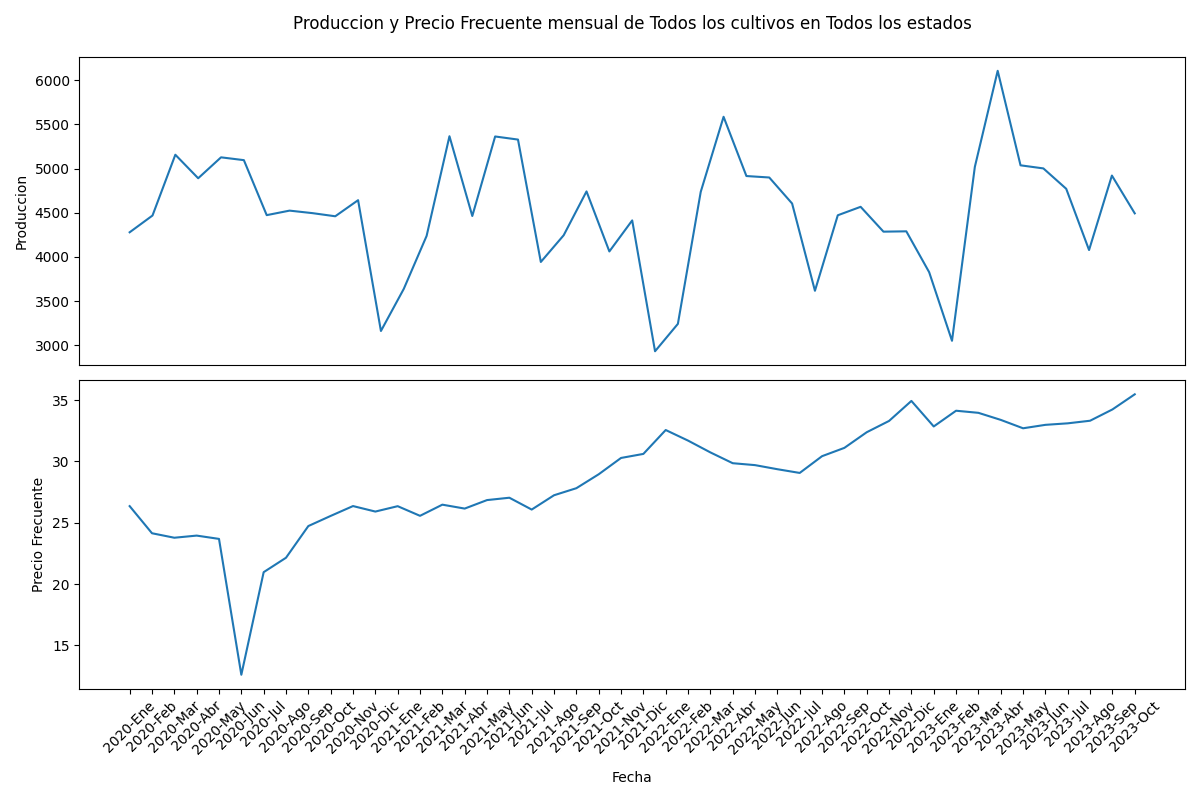

In [119]:
import matplotlib.pyplot as plt
import pandas as pd
import ipywidgets as widgets
from IPython.display import display

# Crear una figura con dos subgráficas
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Agregar la opción "Todos los cultivos" al conjunto de opciones de cultivos
cultivos = ['Todos los cultivos'] + cultivos_unicos

# Crear un widget desplegable para seleccionar cultivos
dropdown_cultivo = widgets.Dropdown(options=cultivos, value=cultivos[0], description='Cultivo:')

# Agregar la opción "Todos los estados" al conjunto de opciones de estados
estados = ['Todos los estados'] + list(prod_ent_año_mes_cult_diff['Entidad'].unique())

# Crear un widget desplegable para seleccionar estado
dropdown_estado = widgets.Dropdown(options=estados, value=estados[0], description='Estado:')

# Añadir un texto para mostrar el coeficiente de correlación
correlation_text = widgets.Text(value='', description='Correlación:', disabled=True)

# Función para actualizar ambas gráficas al cambiar la selección del cultivo y estado
def update_plots(cultivo, estado):
    ax1.clear()
    ax2.clear()

    # Filtrar datos según la selección de cultivo y estado
    if cultivo == 'Todos los cultivos':
        if estado == 'Todos los estados':
            cultivo_data_prod = prod_ent_año_mes_cult_diff.groupby(['Anio', 'Mes'])['Produccion'].mean()
            cultivo_data_prod = cultivo_data_prod.reindex(meses_cronologico, level='Mes').reset_index()  # Ordenamiento de meses cronológicamente
        else:
            cultivo_data_prod = prod_ent_año_mes_cult_diff[prod_ent_año_mes_cult_diff['Entidad'] == estado].groupby(['Anio', 'Mes'])['Produccion'].mean()
            cultivo_data_prod = cultivo_data_prod.reindex(meses_cronologico, level='Mes').reset_index()  # Ordenamiento de meses cronológicamente
    else:
        cultivo_data_prod = prod_ent_año_mes_cult_diff[(prod_ent_año_mes_cult_diff['Cultivo'] == cultivo) & (prod_ent_año_mes_cult_diff['Entidad'] == estado)]

    ax1.plot(
        cultivo_data_prod['Anio'].astype(str) + '-' + cultivo_data_prod['Mes'].str.slice(0, 3),
        cultivo_data_prod['Produccion']
    )
    ax1.set_ylabel('Produccion')
    ax1.set_title(f'Produccion y Precio Frecuente mensual de {cultivo} en {estado}', pad=20)
    ax1.set_xticks([])

    # Filtrar datos de precio frecuente según la selección de cultivo y estado
    if cultivo == 'Todos los cultivos':
        if estado == 'Todos los estados':
            cultivo_data_prec = prec_año_mes_orig_dest.groupby(['Año', 'Mes'])['Precio Frecuente'].mean()
            cultivo_data_prec = cultivo_data_prec.reindex(meses_cronologico, level='Mes').reset_index()  # Ordenamiento de meses cronológicamente
        else:
            cultivo_data_prec = prec_año_mes_orig_dest[prec_año_mes_orig_dest['Origen'] == estado].groupby(['Año', 'Mes'])['Precio Frecuente'].mean()
            cultivo_data_prec = cultivo_data_prec.reindex(meses_cronologico, level='Mes').reset_index()  # Ordenamiento de meses cronológicamente
    else:
        cultivo_data_prec = prec_año_mes_orig_dest[(prec_año_mes_orig_dest['Cultivo SIAP'] == cultivo) & (prec_año_mes_orig_dest['Origen'] == estado)]

    ax2.plot(
        cultivo_data_prec['Año'].astype(str) + '-' + cultivo_data_prec['Mes'].str.slice(0, 3),
        cultivo_data_prec['Precio Frecuente']
    )
    ax2.set_ylabel('Precio Frecuente')
    ax2.set_xlabel('Fecha', labelpad=10)
    ax2.tick_params(axis='x', rotation=45)

    # Calcular y mostrar el coeficiente de correlación
    correlation = cultivo_data_prod['Produccion'].dropna().corr(cultivo_data_prec['Precio Frecuente'].dropna())
    correlation_text.value = f'{correlation:.2f}'

    plt.tight_layout()

# Conectar la función de actualización con el cambio en el valor del widget
interactive_plot = widgets.interactive(update_plots, cultivo=dropdown_cultivo, estado=dropdown_estado)

# Mostrar los widgets y la figura
display(interactive_plot, correlation_text)
